In [1]:
import csv
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

I used only the Python standard libraries and the ones mentioned above - NumPy, Pandas, Scikit-learn and Matplotlib.

***
# 1. Data exploration


I started with downloading the abalone dataset from the link you provided and edited it in MS Excel - added the headers based on the abalone.names file and converted it to the .csv format. Then I loaded it in Python using pandas module:

In [2]:
df = pd.read_csv('abalone_data.csv')
df.head()

,Sex,Length [mm],Diameter [mm],Height [mm],Whole weight [g],Shucked weight [g],Viscera weight [g],Shell weight [g],Number of rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
df.shape

(4177, 9)

It appears that the data has been loaded correctly. Each row represents all the measurements and the number of rings of a single abalone, while each column corresponds to all the measurements of a given feature (e.g. the diameter of each abalone).

In [4]:
#changing the column names to avoid problems with the pandas module
df.columns = df.columns.str.replace(' ', '_')

#the idea is to make a 'population pyramid' 
ring_max = df['Number_of_rings'].max()
ring_min = df['Number_of_rings'].min()
rings = [i for i in range(ring_min, ring_max+1)]
frequencies = []

for ring in rings:
    frequency = (df.Number_of_rings == ring).sum()
    frequencies.append(frequency)

<BarContainer object of 29 artists>

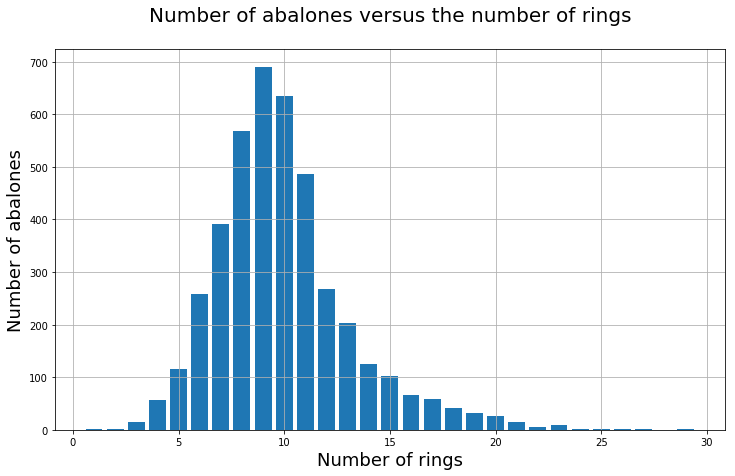

In [5]:
fig = plt.figure(figsize = (12,7))
plt.grid()
plt.title("Number of abalones versus the number of rings\n", fontsize = 20)
plt.xlabel("Number of rings", fontsize = 18)
plt.ylabel("Number of abalones", fontsize = 18)
plt.bar(rings, frequencies)

One can see that the biggest number of abalones corresponds to the number of rings from 5 to 15, which can estimate the age of the majority between 6,5 and 16,5 years. Since the number of samples of the abalons with mroe than 22 and less than 3 rings is rather small the measurements may not be representative for the oldest abalones - and there was no recorded case for an abalon with exactly 28 rings in the data!

There are also some patterns between the number of rings (and therefore the age) and most of the other attributes visible just by looking on the raw data plotted. I also decided to colour the points in three different ways, according to the sex of an abalone, to find out if that matters.

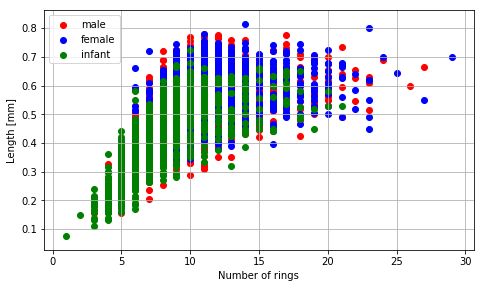

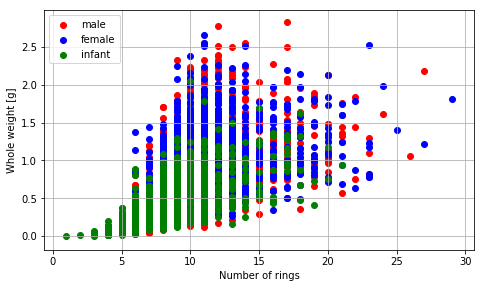

In [6]:
plt.figure(figsize=(7,7))
plt.subplots_adjust(right=2, top=0.6, wspace=0.2)
plt.subplot(1,2,1)
plt.grid()
plt.xlabel('Number of rings')
plt.ylabel('Length [mm]')
plt.scatter(df.loc[df.Sex == 'M', 'Number_of_rings'], df.loc[df.Sex == 'M', 'Length_[mm]'], c = 'r', label = 'male')
plt.scatter(df.loc[df.Sex == 'F', 'Number_of_rings'], df.loc[df.Sex == 'F', 'Length_[mm]'], c = 'b', label = 'female')
plt.scatter(df.loc[df.Sex == 'I', 'Number_of_rings'], df.loc[df.Sex == 'I', 'Length_[mm]'], c = 'g', label = 'infant')
plt.legend(loc = 'upper left')

plt.figure(figsize=(7,7))
plt.subplots_adjust(right=2, top=0.6, wspace=0.2)
plt.subplot(1,2,2)
plt.grid()
plt.xlabel('Number of rings')
plt.ylabel('Whole weight [g]')
plt.scatter(df.loc[df.Sex == 'M', 'Number_of_rings'], df.loc[df.Sex == 'M', 'Whole_weight_[g]'], c = 'r', label = 'male')
plt.scatter(df.loc[df.Sex == 'F', 'Number_of_rings'], df.loc[df.Sex == 'F', 'Whole_weight_[g]'], c = 'b', label = 'female')
plt.scatter(df.loc[df.Sex == 'I', 'Number_of_rings'], df.loc[df.Sex == 'I', 'Whole_weight_[g]'], c = 'g', label = 'infant')
plt.legend(loc = 'upper left')

As expected, the older the abalones, the bigger they are - both in terms of weight and geometric measurements. Similiar analysis can be done for other features, like height or viscera weight. At first I thought an abalon is considered an infant up to the certain age - but the plots show that there are infants with 20 or even 21 rings, they just weigh less and are shorter than the other abalons of the same age. On the other hand, male and female abalons do not differ much from each other. There are single units of both sex which are slighty bigger or slightly smaller than the rest of the population.

Another idea is to plot their length versus diameter:

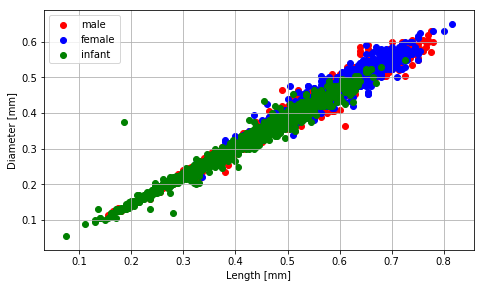

In [7]:
plt.figure(figsize=(7,7))
plt.subplots_adjust(right=2, top=0.6, wspace=0.2)
plt.subplot(1,2,1)
plt.grid()
plt.xlabel('Length [mm]')
plt.ylabel('Diameter [mm]')
plt.scatter(df.loc[df.Sex == 'M', 'Length_[mm]'], df.loc[df.Sex == 'M', 'Diameter_[mm]'], c = 'r', label = 'male')
plt.scatter(df.loc[df.Sex == 'F', 'Length_[mm]'],df.loc[df.Sex == 'F', 'Diameter_[mm]'], c = 'b', label = 'female')
plt.scatter(df.loc[df.Sex == 'I', 'Length_[mm]'], df.loc[df.Sex == 'I', 'Diameter_[mm]'], c = 'g', label = 'infant')
plt.legend(loc='upper left')

Which, interestingly, shows almost perfect linear correlation between those two . It does not matter if an abalone is young, old, male, female or even an infant - their shape is almost the same through their whole life, they just grow in size.

And their whole weight versus length:

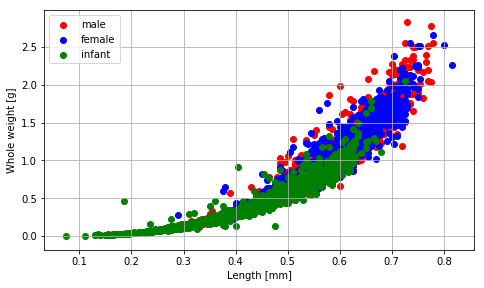

In [8]:
plt.figure(figsize=(7,7))
plt.subplots_adjust(right=2, top=0.6, wspace=0.2)
plt.subplot(1,2,2)
plt.grid()
plt.xlabel('Length [mm]')
plt.ylabel('Whole weight [g]')
plt.scatter(df.loc[df.Sex == 'M', 'Length_[mm]'], df.loc[df.Sex == 'M', 'Whole_weight_[g]'], c = 'r', label = 'male')
plt.scatter(df.loc[df.Sex == 'F', 'Length_[mm]'], df.loc[df.Sex == 'F', 'Whole_weight_[g]'], c = 'b', label = 'female')
plt.scatter(df.loc[df.Sex == 'I', 'Length_[mm]'], df.loc[df.Sex == 'I', 'Whole_weight_[g]'], c = 'g', label = 'infant')
plt.legend(loc = 'upper left')

Not as perfect as the previous plot, but close to the linear dependance.

***
# 2. Supervised learning

##### Prepare the data for the modeling.  

###### Choose 2 supervised learning algorithms, that you think are suitable for this problem. Describe shortly how these algorithms work. Use them on the data and describe the results.  
  
Note. that we're more interested in comprehensive description and explanation of your choice than in model scores, so we don't expect you to tune your model yet.

In the first place I am going to prepare the data. As the rows with missing values has already been removed there is no need to do that. The goal is to split the data into the matrix of features (X) and the vector of ground-truth values for each abalone (y - the number of rings) to use them later for training and test purposes. A single row in the matrix corresponds to all the features of a single abalone and a single column to a single feature of all the abalones e.g. whole weight.

I have never encountered string features before so I am not sure what to do with the sex - and simply converting them to interers like M = 0, F = 1 and I = 2 would not be good, because it would mean to the classification algorithms that somehow an infant is 'more important' than a male or a female. But I came up with an idea to translate it to booleans, creating three new columns in the X matrix: is_male, is_female and is_infant, value of 1 meaning this is the sex of a given abalone. This way I increased the total number of features, but made sure they are all 'equal'.

In [9]:
features = ['Sex', 'Length_[mm]', 'Diameter_[mm]', 'Height_[mm]', 'Whole_weight_[g]','Shucked_weight_[g]',
       'Viscera_weight_[g]', 'Shell_weight_[g]']
X = df[features]
y = df['Number_of_rings']

pd.options.mode.chained_assignment = None
X.insert(loc=0, column='is_male', value = 0)
X.insert(loc=0, column='is_female', value = 0)
X.insert(loc=0, column='is_infant', value = 0)
X.is_female[df.Sex == 'F'] = 1
X.is_male[df.Sex == 'M'] = 1
X.is_infant[df.Sex == 'I'] = 1
X.drop('Sex', 1, inplace=True)
X.head()

,is_infant,is_female,is_male,Length_[mm],Diameter_[mm],Height_[mm],Whole_weight_[g],Shucked_weight_[g],Viscera_weight_[g],Shell_weight_[g]
0,0,0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,0,0,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,0,1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,0,0,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,1,0,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


At this moment we have the matrix X and vector y in the right forms, ready to start some calculations. Inspired by the past usage of this database, I split them into two sets: 75% of the examples became the training set and the other 25% the test set, to avoid trying to memorize the dataset by the model. As the first algorithm, I used the k-nearest neighbors from the sklearn module.

This algorithm tries to classify the new object (one from the test data) as a member of the class corresponding to its k-nearest neighbours (the training points). For k = 1, it will simply become the class of the nearest neighbour. For k > 1, the class is chosen among the most common of the nearest neighbours. The default metric in sklearn for this algorithm is minkowski, which, with the other default parameters, is equivalent to the standard Euclidean metric. When a new data row describing a single abalone is given with an intention to predict the rings value, the algorithm iterates through all the training points and tries to find the nearest ones in terms of the mentioned metric.

In [10]:
#splitting the data in the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

#implementing the KNN algorithm
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)

#making predictions based on the training and test inputs
y_pred = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

print('Test accuracy: ' + str(round(metrics.accuracy_score(y_test, y_pred)*100, 2)) + '%.')
print('Training accuracy: ' + str(round(metrics.accuracy_score(y_train, y_pred_train)*100, 2)) + '%.')

Test accuracy: 20.38%.
Training accuracy: 100.0%.


For the test set, I got about 20% accuracy, which, I would say, is satisfactory considering the fact this is not an easy classification problem with 29 different classes and the k parameter is not yet optimized. For the training set and k = 1 100% accuracy means that the model has memorized the whole training set, thus overfitting the problem. In task 5 I will try to optimize this parameter, as for higher values of k in KNN the model is less complicated and better at generalizing the data.

The next observation is that the results would be a lot better if (like the past authors scores mentioned in the documentation) we would consider this problem as 3-category classification (grouping together rings 1-8, 9-10 and 11 and more). But since the target variable is Rings + 1.5 and we would like to know the exact age of an abalone, we also would like the model to predict the exact number of rings and not the range where it can be. Still, to at least compare the results with the past work, I copied and edited the original y vector, so that 0 corresponds to 1-8 rings, 1 to 9 or 10 and 2 to 11 or more.

In [11]:
y_new = y.copy()

for i in range(len(y_new)):
    if y_new[i] in range(1, 9):
        y_new[i] = 0
    elif (y_new[i] == 9 or y_new[i] == 10):
        y_new[i] = 1
    else:
        y_new[i] = 2

Now we can check the accuracy in this 3-category classification problem:

In [12]:
X_train, X_test, y_new_train, y_new_test = train_test_split(X, y_new, test_size = 0.25)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_new_train)
y_pred = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

print('Test accuracy: ' + str(round(metrics.accuracy_score(y_new_test, y_pred)*100, 2)) + '%.')
print('Training accuracy: ' + str(round(metrics.accuracy_score(y_new_train, y_pred_train)*100, 2)) + '%.')

Test accuracy: 61.63%.
Training accuracy: 74.01%.


For k = 5 the results are almost identical to the ones achieved by Waugh, 1995.

From now to the end, I will focus only on the harder problem, since our target value is no more, no less, but exactly Rings + 1.5, roughly corresponding to the age of a given abalone. The second algorithm I am going to use and which is great for classification tasks is a multi-layer perceptron algorithm, again from the sklearn module.

This algorithm is based on the layers of neurons, connected with each other in a similiar way like in a human brain. The first layer are input neurons (all the measurements (features) of abalones) and the last layer are output neurons (the prediction what class the abalone belongs to). Each neuron in a given layer is connected to all the neurons in the previous layer and each of the connection has a weight associated with it (this is a model of fully connected neural network). Every neuron apart from the input ones computes the sum of its inputs (each multiplied by its weight) with the bias term added and passes it through some kind of activation function (like sigmoid) to the next neuron.

The goal is to define the cost function (sklearn's MLPClassifier supports only cross-entropy), which describes the difference between the predicted and the real value for a given input, and then modify the weights and biases in a way to minimize that cost function - this process is called training the neural network.

As an algorithm used to optimize the weights I used the Stochastic Gradient Descent, which computes the gradient of the cost function with respect to every single weight and bias using backpropagation and the chain rule, and then updates the weights taking small steps in the opposite direction in order to minimize the cost faction. The hyperparameter describing the size of those steps is called the learning rate and will be optimized in task nr 5.

Now to train the network and make some predictions. I added the random_state parameter, so I can play with the number and size of hidden layers avoiding the variance (casued by randomizing weights each time the MLP is initialized, and thus approaching different local minimums) and I found out that 10 and 5 neurons in the 1st and 2nd hidden layer respectively work pretty well for this dataset. As told, I am not experimenting with the learning rate yet, but I increased the maximum number of iterations, so the algorithm can at least converge.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

clf = MLPClassifier(solver='sgd', max_iter = 2000, hidden_layer_sizes=(10, 5), random_state = 1)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print('Test accuracy: ' + str(round(metrics.accuracy_score(y_test, y_pred)*100, 2)) + '%.')
print('Training accuracy: ' + str(round(metrics.accuracy_score(y_train, y_pred_train)*100, 2)) + '%.')

Test accuracy: 25.65%.
Training accuracy: 28.86%.


Note that the model is slightly overfitting the problem. Furthermore, we would achieve faster convergence using Adam optimizer with default parameters, but since the learning rate in this solver adapts on its own and is not tunable I am going to stay with the SGD for the purpose of task nr 5.


# 3. Dimensionality reduction


##### What are the applications of the dimensionality reduction?   

###### Pick two algorithms that could be useful for exploration or supervised learning problem and apply them on the data. Describe what you've found. Provide a short description of the algorithms you've chosen.

Note: feature selection is also one type of dimensionality reduction.

Dimensionality reduction is most useful when each of the data examples consists of hundreds (or thousand) of features. Then not only the learning is slow, but also it is often hard to find a good solution as it can make the model very complicated. As the features are usually highly correlated with each other or irrelevant at all, we do not lose much information by dimensionality reduction and we speed up the learning process.

A perfect example to applicate the dimensionality reduction would be the well+known MNIST dataset of handwritten digits: as the features are the greyscale values and the image is 28x28 pixels, we have got 784 dimensions. But by assuming the corner pixels are always irrelevant to the classification problem and as any two adjecent pixels are usually correlated, by taking the mean greyscale value we can reduce the number of dimensions several times.

Dimensionality reduction is also helpful for visualizing the data with many dimensions, as we humans have problems with more than three - surely we live in just three-dimensional space!

For an algorithm used to experiment with dimensionality reduction useful for supervised learning, as I am doing this task after task nr 5, I chose the KNN with optimal k value equal 36. Starting with the feature selection, I am going to use SelectKBest from sklearn, with the Chi-Squared chosen as the statistical test. SelectKBest will compute it between each feature of X and y - a small value will mean the feature is independent of y and a large value will mean that this certain feature probably contain some important information, and this way the most relevant features will be selected.

In [14]:
#I decided to split the X matrix into two: the one with the booleans value of sex and the one with the rest of features
#and ran the SelectKBest only on the measurements, then manually adding the sex columns to check if that improves the model accuracy

X_sex = X.values[:, :3]
X_features = X.values[:, 3:]
y_red = y.values

In [15]:
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X_features, y_red)
X_features = fit.transform(X_features)
print(X_features)
print('\n', X_features.shape)

[[0.514  0.2245 0.15  ]
 [0.2255 0.0995 0.07  ]
 [0.677  0.2565 0.21  ]
 ...
 [1.176  0.5255 0.308 ]
 [1.0945 0.531  0.296 ]
 [1.9485 0.9455 0.495 ]]

 (4177, 3)


It is interesting though that the SelectKBest algorithm chose the whole weight, shucked weight and shell weight entirely getting rid of all the geometric measurements like the length. But, as we saw earlier, all of the features are somehow dependent on each other, for example whole weight being almost a linear function of length.

Now, to compare the accuracy and execution time (as for KNN, most of the time is actually not the fitting, but the predicting of output), I am going to ran the algorithm 100 times for three different feature matices - the original one and the one selected by SelectKBest with and without the sex columns.

In [16]:
#original feature matrix
accuracies_train = []

t0 = time()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    knn = KNeighborsClassifier(n_neighbors = 36)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies_train.append(metrics.accuracy_score(y_pred, y_test))
t1 = time()

print('Accuracy for the original feature matrix: ' + str(round(np.mean(accuracies_train)*100, 2)) + '%.')
print('Time taken: ' + str(round(t1 - t0, 2)) + 's.')

Accuracy for the original feature matrix: 26.29%.
Time taken: 2.76s.


In [17]:
#selected feature matrix without sex columns
accuracies_train = []
t0 = time()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.25)
    knn = KNeighborsClassifier(n_neighbors = 36)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies_train.append(metrics.accuracy_score(y_pred, y_test))
t1 = time()

print('Accuracy for the selected feature matrix without sex columns: ' + str(round(np.mean(accuracies_train)*100, 2)) + '%.')
print('Time taken: ' + str(round(t1 - t0, 2)) + 's.')

Accuracy for the selected feature matrix without sex columns: 26.63%.
Time taken: 1.36s.


In [18]:
#selected feature matrix with sex columns
X_red_sex = np.concatenate((X_sex, X_features), axis=1)
accuracies_train = []

t0 = time()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_red_sex, y, test_size = 0.25)
    knn = KNeighborsClassifier(n_neighbors = 36)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies_train.append(metrics.accuracy_score(y_pred, y_test))
t1 = time()

print('Accuracy for the selected feature matrix with sex columns: ' + str(round(np.mean(accuracies_train)*100, 2)) + '%.')
print('Time taken: ' + str(round(t1 - t0, 2)) + 's.')

Accuracy for the selected feature matrix with sex columns: 26.62%.
Time taken: 1.94s.


The accuracies are almost the same - it means that by dimensionality reduction we did not lose any important data. There is a small time improvement when the feature matrix width is reduced from 10 to 3 - the process is about 2 times faster. The difference would be bigger if the dimensionality reduction had been done for example from thousands to hundreds or if a different supervised algorithm had been used.

Another common pick used in dimensionality reduction is called Principal Component Analysis. Basically PCA creates a hyperplane and then projects all the data points onto it. It can be compared to projecting the points in two-dimensional space onto a single line. The PCA algorithm tries to find such hyperplane, that the projected polints will have maximum variance - and, therefore, the least possible amount of information will be lost in the process.

Going more into details, there is a technique of matrix factorization called sinular value decomposition. The class PCA from the sklearn module implements the PCA analysis using the SVD, in order to find such axes, so the projected points will have maximum variance. Fortunately, sklearn makes it very simple to apply: all I have to do is pass it the number of dimensions I want to finally have in X matrix.

In [19]:
#checking the impact of the number of PCA dimensions on the accuracy and time taken to execute
times = []
dimensions_accuracy = []

#loop for dimensions from 1 to 10
for j in range(1, 11):
    accuracies_train = []
    pca = PCA(n_components = j)
    X_projected = pca.fit_transform(X)
    
    #measuring time, training KNN model for each X_projected matrix
    t0 = time()
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X_projected, y, test_size = 0.25)
        knn = KNeighborsClassifier(n_neighbors = 36)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracies_train.append(metrics.accuracy_score(y_pred, y_test))
    t1 = time()
    
    #appending the dimensions_accuracy and times list for every dimensions value
    dimensions_accuracy.append(round(np.mean(accuracies_train), 3))
    times.append(round(t1 - t0, 2))

Text(0, 0.5, 'Time [s]')

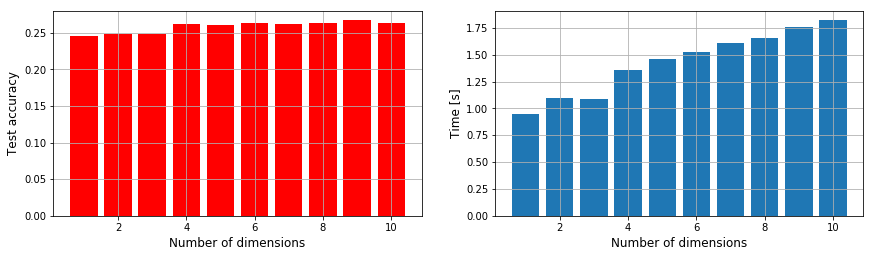

In [20]:
#now to plot the results
dimensions = [i for i in range(1,11)]
plt.figure(figsize=(6,6))
plt.subplots_adjust(right=2, top=0.6, wspace=0.2)
plt.subplot(1,2,1)
plt.grid()
plt.bar(dimensions, dimensions_accuracy, color = 'r')
plt.xlabel('Number of dimensions', fontsize = 12)
plt.ylabel('Test accuracy', fontsize = 12)

plt.subplot(1,2,2)
plt.grid()
plt.bar(dimensions, times)
plt.xlabel('Number of dimensions', fontsize = 12)
plt.ylabel('Time [s]', fontsize = 12)

Of course the time gets lower as we project the points onto lower dimension hyperplanes, as it takes less computations to train the model and predict the outputs when there are less columns in the feature matrix. The accuracy stays almost the same. There is a small drop comparing 3 to 4 dimensions, but still the model is able to maintain about 25% even when the points are projected onto a single one-dimensional line.


# 4. Hyperparameter selection and crossvalidation

##### We imagine that you did some modeling in 2nd task with the methods that have some tunable hyperparameters. If they don't, either find a versions of them that have that are tunable, or pick the different ones.

##### Tune the hyperparameters of your model using cross-validation. Does it make it better? Does it solve overfitting problems? Is cross-validation score worse than score that your model achieves on test set?

There is a problem with cross-validation on this dataset: when the data is split into K folds, the classes should be represented with equal proportions in each of the K folds. As we do not have enough examples of the youngest and the oldest abalones, sklearn will produce a warning when trying to divide the data.

Anyway, I chose to ignore the warning and started with optimizing the hyperparameter for the k-nearest neighbors algorithm using cross-validation. The cross_val_score function in the for loop below uses one fold as the test set and the rest as the training set, which is then repeated for every fold (10 times for each value of k). It returns a list of accuracies for the certain k value and then the mean of them is added to knn_accuracies_test list.

In [21]:
#hiding the warnings about the minimum number of members in classes when splitting the data using cross-validation
warnings.filterwarnings("ignore", category=Warning) 

#creating a list of reasonable k values to look for the best for the model
k_list = [k for k in range(1,101)]
knn_accuracies_test = []

#searching for the optimal value of k
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn_accuracies = cross_val_score(knn, X, y, cv = 10, scoring = 'accuracy')
    knn_accuracies_test.append(knn_accuracies.mean())

Text(0, 0.5, 'Test accuracy')

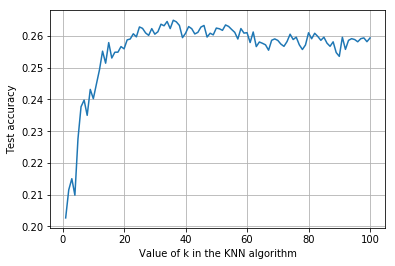

In [22]:
plt.plot(k_list, knn_accuracies_test)
plt.grid()
plt.xlabel('Value of k in the KNN algorithm')
plt.ylabel('Test accuracy')

In [23]:
k_max = knn_accuracies_test.index(max(knn_accuracies_test)) + 1
print('The best test accuracy: ' + str(round(max(knn_accuracies_test)*100, 2)) + 
      '%, for k = ' + str(k_max) + '.')

The best test accuracy: 26.5%, for k = 36.


The result is pretty good - optimizing the k parameter happened to increase the initial model test accuracy (for k = 1) from around 20% to 26,5%. Finally I would like to plot the training vs test accuracy for different k values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
k_list = [k for k in range(1,101)]
knn_accuracies_train = []

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    knn_accuracies_train.append(metrics.accuracy_score(y_pred_train, y_train))

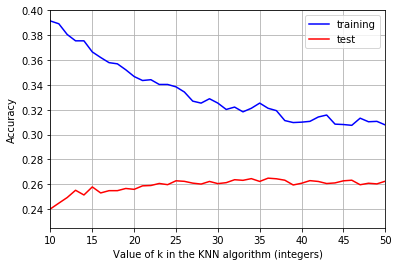

In [25]:
plt.xlabel('Value of k in the KNN algorithm (integers)')
plt.ylabel('Accuracy')
plt.grid()
plt.axis((10,50,0.225,0.4))
plt.plot(k_list, knn_accuracies_train, 'b', label='training')
plt.plot(k_list, knn_accuracies_test, 'r', label='test')
plt.legend(loc='upper right')

It is not really visible just by looking at this plot, but around k = 36 the test accuracy in fact starts to decrease, thus at k = 36 the model is the best at generalizing data and finding the relationship between the measurements and the number of rings. When k is small, the model is trying to memorize the training data (overfitting) and when k is big, the model is not complex enough (underfitting).

Now it comes to optimize the parameters of the neural network. There are many variables which are said to be hyperparameters of an ANN, like number of the hidden layers and neurons in each of them, activation function, regularization terms etc., but I will try to optimize only the learning rate parameter and choose the others by intuition. Same as in the KNN case, I am going to create a list of reasonable values of learning rate and then iterate through all of them using cross-validation. A small warning: even though I reduced the number of cross-validation folds from 10 to 5, the cell below has a really long computation time (about 5 minutes on my computer).

In [26]:
lr1 = np.arange(1e-5, 1e-4, 1e-5)
lr2 = np.arange(1e-4, 1e-3, 1e-4)
lr3 = np.arange(1e-3, 1e-2, 1e-3)
lr4 = np.arange(0.01, 0.1, 0.01)
lr5 = np.arange(0.1, 1, 0.1)
lr_list = np.concatenate((lr1, lr2, lr3, lr4, lr5), axis = None)
clf_accuracies_test = []

for lr in lr_list:
    clf = MLPClassifier(solver='sgd', activation = 'tanh', learning_rate_init = lr, 
                        hidden_layer_sizes=(10, 5), random_state = 1)
    clf_accuracies = cross_val_score(clf, X, y, cv = 5, scoring = 'accuracy')
    clf_accuracies_test.append(clf_accuracies.mean())

Text(0, 0.5, 'Accuracy on the test set')

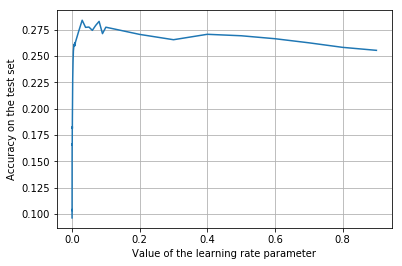

In [27]:
plt.plot(lr_list, clf_accuracies_test)
plt.grid()
plt.xlabel('Value of the learning rate parameter')
plt.ylabel('Accuracy on the test set')

In [28]:
lr_max_index = clf_accuracies_test.index(max(clf_accuracies_test)) 
lr_max = lr_list[lr_max_index]
print('The best test accuracy: ' + str(round(max(clf_accuracies_test)*100, 2)) + 
      '%, for learning rate = ' + str(round(lr_max, 5)) + '.')

The best test accuracy: 28.39%, for learning rate = 0.03.


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

clf = MLPClassifier(solver='sgd', activation = 'tanh', learning_rate_init = lr_max, 
                    hidden_layer_sizes=(10, 5), random_state = 1)
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
print('Train accuracy for k = ' + str(round(lr_max, 5)) + ': ' + str(round(metrics.accuracy_score(y_pred_train, y_train)*100, 2)) + '%.')

Train accuracy for k = 0.03: 28.48%.


As the training accuracy is very close to test accuracy, the network's complexity seems to be just right. Improving from 25.65% with the default parameters to 28.39% with the optimized learning rate, this is the best score I managed to achieve on this dataset. By playing with the other hyperparameters of the network, one could probably reach around 30% accuracy. Grid search could be done - scanning through different values of learning rate, activation function, alpha regularization term and so on, and choosing the best set of them. SGD is also not the best option to calculate the gradient. Another idea would be to implement Batch Gradient Descent, which updaties the weights after calculating the mean gradient using - let's say - 100 training examples, therefore the path is less flucuating when approaching the minimum of the cost function.